In [ ]:
# -*- coding: utf-8 -*-
import cantera as ct
import numpy as np
import os


2.6.0


In [3]:
# -----------------------
# 用户参数（可改）
# -----------------------
p = ct.one_atm            # 压力
tin_f = 290            # 燃料侧温度
tin_o = 290            # 氧化剂侧温度
width  = 0.02             # m, 两入口间距 2 cm
loglevel = 1              # 输出等级 0-5
comp_o = 'O2:0.21, N2:0.79'  # air composition
comp_f = 'O2:0.167, N2:0.645, NH3:0.117,  H2:0.071' # fuel composition
gas = ct.Solution('Han_35s177r.yaml')
gas.TPX = tin_o, p, comp_o
rho_o = gas.density    # 单位：kg/m³
gas.TPX = tin_f, p, comp_f
rho_f = gas.density    # 单位：kg/m³
u_o=0.9 #单位 m/s
u_f=0.6 #单位 m/s
mdot_o=rho_o * u_o
mdot_f=rho_f * u_f
print("mdot_o=", mdot_o)
print("mdot_f=", mdot_f)

CanteraError: 
*******************************************************************************
CanteraError thrown by Application::findInputFile:

Input file Han_35s177r.yaml not found in directories 
'.', 
'/opt/anaconda3/lib/python3.8/site-packages/cantera/data', 
'/Applications/Cantera/data'

To fix this problem, either:
    a) move the missing files into the local directory;
    b) define environment variable CANTERA_DATA to
         point to the directory containing the file.
*******************************************************************************


In [4]:
# 氧化剂：空气（含少量Ar）
comp_o_air = 'O2:0.21, N2:0.79'

# 目标：燃料侧“预混气”最终想达到的成分
target_fuel_premix = {'O2':0.167, 'N2':0.645, 'NH3':0.117,  'H2':0.071}  # 相对配比, Cantera 会归一化

# 分步过渡的步数（越多越稳，速度越慢）
n_steps = 5  # 会用 0.2, 0.4, ..., 1.0

# 机理：用 gri30 省心（含 H2/O2/N2/AR）
gas = ct.Solution('Han_35s177r.yaml')
gas.TP = tin_o, p

# -----------------------
# 构建 1D 对撞流
# -----------------------
f = ct.CounterflowDiffusionFlame(gas, width=width)

# 传输模型（Mix 更稳，Multi 更精确但更难收敛）
f.transport_model = 'Mix'

# 网格细化准则（适中保守）
f.set_refine_criteria(ratio=3.0, slope=0.06, curve=0.12)

# 入口：先做“纯扩散火焰”——燃料端纯H2，氧化剂端空气
f.fuel_inlet.mdot = mdot_f
f.fuel_inlet.T = tin_f
f.fuel_inlet.X = 'NH3:0.4,H2:0.45'

f.oxidizer_inlet.mdot = mdot_o
f.oxidizer_inlet.T = tin_o
f.oxidizer_inlet.X = comp_o_air

# -----------------------
# 第0步：求稳的“暖启动”解（纯H2 vs 空气）
# -----------------------
def robust_solve(flame, _log=1):
    """稳健求解：先关能量后开，再全自由度。避免自动初值。"""
    try:
        # 先试一次简单解；如果失败再用分阶段
        flame.solve(_log, refine_grid=True, auto=True)
        return
    except ct.CanteraError:
        pass  # 用下面的保守方案

    # 分阶段：先关能量，再开能量
    flame.energy_enabled = False
    flame.solve(_log, refine_grid=True, auto=False)
    flame.energy_enabled = True
    flame.solve(_log, refine_grid=True, auto=False)

robust_solve(f, loglevel)

d:\py\Anaconda3\envs\ct-env\Lib\site-packages\cantera\onedim.py:194: DeprecationWarning: FactoryBase::canonicalize: Model name 'Mix' is deprecated. Use 'mixture-averaged' instead.
  self.flame.transport_model = model



************ Solving on 6 point grid with energy equation enabled ************

..............................................................................

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 8.009e-06  log(ss)= 5.858     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.0001368  log(ss)= 4.8       

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.0005196  log(ss)= 4.914     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.003945   log(ss)= 4.022     

Attempt Newton solution of steady-state problem.
Newton steady-state solve succeeded.

Problem solved on [6] point grid(s).

..............................................................

In [10]:
# -----------------------
# 渐进：把燃料侧从纯H2过渡到  H2:1, O2:1, N2:3.76
# -----------------------

f.set_max_grid_points("flame", 20000)   # 放宽上限
alphas = np.linspace(0.2, 1.0, n_steps)  # 0.2, 0.4, ..., 1.0
for a in alphas:
    comp_f = f"H2:{target_fuel_premix['H2']}, O2:{a*target_fuel_premix['O2']}, N2:{a*target_fuel_premix['N2']},NH3:{a*target_fuel_premix['NH3']}"
    f.fuel_inlet.X = comp_f
    # 继续沿用已有解作为初值，禁止自动初值（避免触发 stoich 计算）
    f.solve(loglevel, refine_grid=True, auto=False)
    print(f"[step] fuel side now: {comp_f}")

# -----------------------
# 输出结果
# -----------------------

# 简单诊断：峰值温度与火焰位置（温度最大点坐标）
x = f.grid
T = f.T
i_max = T.argmax()
print(f"Peak T = {T[i_max]:.2f} K at x = {x[i_max]*1000:.2f} mm")


..............................................................................

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.0003844  log(ss)= 3.926     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.0002737  log(ss)= 5.767     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 5.132e-05  log(ss)= 6.445     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 5.132e-05  log(ss)= 6.713     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 5.132e-05  log(ss)= 6.768     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps

C:\Users\lenovo\AppData\Local\Temp\ipykernel_36532\3547321246.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


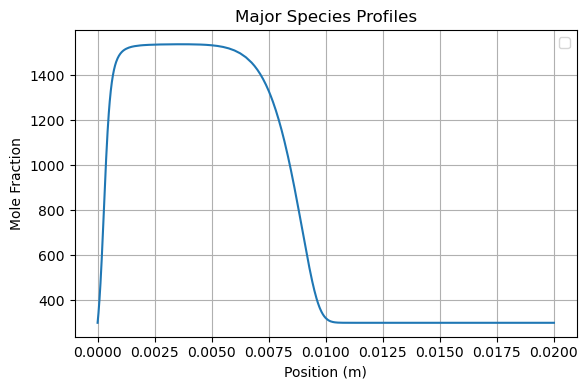

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))

plt.plot(x,T)

plt.xlabel("Position (m)")
plt.ylabel("Temperature")
plt.title("T profile")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()